## YAMnet classification by segmentation | initial dataset training and testing

In [10]:
%load_ext autoreload
%autoreload 2
TRAIN=True

import tensorflow as tf
from tensorflow  import keras
# import tensorflow_hub as hub
import numpy as np

import librosa 
from dataset import WavDataset
from config import *
import matplotlib.pyplot as plt

import h5py
from pathlib import Path
from config import INTERMEDIATE, MODEL_DIR
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from tensorflow_ranking.python.metrics import mean_average_precision

## Data
- all 5 second overlapping chunks have been pregenerated under ../output/intermediate/train.hdf5 (untracked on github).
- YAMnet produces a 1024-long feature vector per 0.96s windows with a 0.48s hop. Thusly 10 frames are predicted per chunk
- labels encoded as binary frame-wise time steps (4 signal classes)

In [12]:
hdf5_dataset = h5py.File(INTERMEDIATE / 'embed.hdf5', 'r')
recordings = np.array(hdf5_dataset)

rec =  recordings[0]

annotated = [
    rec for rec in recordings if np.array(hdf5_dataset[rec]['Y']).sum() > 0
]
len(annotated), hdf5_dataset[rec]['X'].shape

(101, (1249, 1024))

In [13]:
def get_embedding_frames(rec):
    return [
        (rec, i) for i in range(hdf5_dataset[rec]['X'].shape[0])
    ]

embeddings_frames = []
for rec in recordings:
    embeddings_frames.extend(get_embedding_frames(rec))

len(embeddings_frames)

442080

In [14]:
X_shape = (1024,)
Y_shape = (4,)

def embedding_frame_generator(frames):
    for (rec, frame_idx) in frames:
        group =  hdf5_dataset[rec]
        yield (
            np.array(group['X'][frame_idx, :]), 
            np.array(group['Y'][frame_idx, :])
        ) 

raw_dataset = tf.data.Dataset.from_generator( 
    lambda: embedding_frame_generator(embeddings_frames), 
    output_signature=(
        tf.TensorSpec(shape=X_shape, dtype=tf.float32),
        tf.TensorSpec(shape=Y_shape, dtype=tf.bool)))

# test
for s in raw_dataset.take(32):
    X, Y = s    
    print(np.array(X).sum(), np.array(Y).sum(), end="\t\t")

print(X.shape, Y.shape)

57.00635 0		58.285202 0		59.04304 0		56.71453 0		57.66487 0		50.090828 0		53.10558 0		63.703053 0		69.35723 0		67.904816 0		64.400475 0		58.83925 0		53.16173 0		59.326614 0		60.24948 0		57.349216 0		58.80186 0		53.310894 0		61.443405 0		52.015244 0		48.812256 0		66.87404 0		65.887695 0		59.561172 0		65.36894 0		

68.77638 0		65.38515 0		52.331062 0		58.556824 0		58.854324 0		63.58287 0		62.07183 0		(1024,) (4,)


In [15]:
n_frames = len(embeddings_frames) 

# shuffle
np.random.seed(0)
np.random.shuffle(embeddings_frames) # TODO add order to model dir

# split chunks test/train/valid
test_cut = int(n_frames * 0.8)
valid_cut = int(test_cut * 0.8) 

train_valid_frames, test_frames = embeddings_frames[:test_cut], embeddings_frames[test_cut:]
train_frames, valid_frames = train_valid_frames[:valid_cut], train_valid_frames[valid_cut:]

spec = (tf.TensorSpec(shape=X_shape, dtype=tf.float32),
        tf.TensorSpec(shape=Y_shape, dtype=tf.bool))

train_dataset = tf.data.Dataset.from_generator(lambda: embedding_frame_generator(train_frames), output_signature=spec)
valid_dataset = tf.data.Dataset.from_generator(lambda: embedding_frame_generator(valid_frames), output_signature=spec)
test_dataset = tf.data.Dataset.from_generator(lambda: embedding_frame_generator(test_frames), output_signature=spec)

print(
    len(train_frames), len(valid_frames), len(test_frames)
)

# test
for s in test_dataset.take(32):
    X, Y = s    
    print(np.array(X).sum(), np.array(Y).sum(), end="\t\t")

print(X.shape, Y.shape)

282931 70733 88416
60.842175 0		47.82476 0		54.555904 0		61.86556 0		61.835472 0		67.81091 0		58.046566 0		65.891846 0		57.639008 0		32.331863 0		110.26908 0		76.39511 0		95.3487 0		68.34055 0		71.22916 0		92.37334 0		65.82136 0		59.175117 0		87.79456 0		61.882133 0		51.60492 0		43.89224 0		64.7926 0		66.20942 0		64.93405 0		65.88392 0		60.481377 0		68.009964 0		57.63435 0		60.891483 0		58.212757 0		59.831745 0		(1024,) (4,)


## Training
Using a simple DNN against the embeddings (** check??)

In [16]:
from keras.layers import Input, Dense, BatchNormalization
# import tensorflow_addons as tfa
from functools import partial
from keras import metrics

def create_model(output_bias=None) -> keras.Model:
    # default_dense =  partial(Dense, activation='selu', # self normalizing
    #                          kernel_initializer=keras.initializers.LecunNormal(seed=0)
    #                         ) # kernel_regularizer ?
    default_dense =  partial(Dense, activation='relu', 
                             kernel_initializer=keras.initializers.LecunNormal(seed=0)
                            ) # kernel_regularizer ?
    
    # simple head for YAMnet base
    return keras.Sequential([
            Input(shape=(1024,)),
            default_dense(512), 
            Dense(4, activation='sigmoid', 
                  bias_initializer=output_bias) # correct this 
    ])

def compile(model):
    thresh = np.arange(10) * 0.1
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  
        metrics=[
            metrics.Recall(thresholds=0.5),
            metrics.Precision(thresholds=0.5),
            metrics.AUC(curve='pr'),
        ]
    )

model = create_model()
compile(model)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 526852 (2.01 MB)
Trainable params: 526852 (2.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# 133921 chunks
# 4185 batches

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import pandas as pd

# class IncrementallySavedCheckpoint(tf.keras.callbacks.Callback):
#     def __init__(self, checkpoint_dir, **kwargs):
#         super().__init__()
#         self.checkpoint_dir = checkpoint_dir
    
#     def on_epoch_end(self, epoch, logs=None):
#         checkpoint_path = Path(self.checkpoint_dir) / f'model_epoch_{epoch+1}.ckpt'
#         self.model.save_weights(checkpoint_path)
#         print(f"Saved checkpoint for epoch {epoch+1} at {checkpoint_path}")


def train(model, model_dir, stopping_patience=5, 
          stopping_moniter='val_loss', **kwargs):
    
    model_dir.mkdir(exist_ok=True)

    # save frame order
    np.save(model_dir / 'train_frames.npy', train_frames)
    np.save(model_dir / 'valid_frames.npy', valid_frames)
    np.save(model_dir / 'test_frames.npy', test_frames) 

    # tensorboard
    log_dir = model_dir / "logs" / "fit"
    log_dir.mkdir(parents=True, exist_ok=True)
    tensorboard_callback = TensorBoard(log_dir=log_dir)

    # checkpoints
    checkpoint_path = model_dir / "training"
    Path(checkpoint_path).mkdir(exist_ok=True)  
    cp_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_path / 'checkpoint.weights.h5', 
        save_weights_only=True,
        verbose=1, 
    )

    # early stopping
    es_checkpoint = EarlyStopping(
        monitor=stopping_moniter,
        patience=stopping_patience,
        restore_best_weights=True,
    )
    
    # fit
    history = model.fit(
        verbose=2,
        callbacks=[tensorboard_callback, cp_callback, es_checkpoint],
        **kwargs
    )
    model.save(model_dir / 'model.keras')
    df = pd.DataFrame(history.history)
    df.to_csv("logs/history.csv")
    return history

    
if TRAIN:
    batch = 64 # try 128 / 256
    epochs = 20
    history = train(
        x=train_dataset.batch(batch).prefetch(tf.data.AUTOTUNE), 
        validation_data=valid_dataset.batch(batch).prefetch(tf.data.AUTOTUNE),
        model=model, 
        model_dir=MODEL_DIR / "20e_embedding_frames", 
        epochs=epochs, 
    )
    
    

Epoch 1/20


2024-09-20 12:47:57.629121: W tensorflow/core/framework/op_kernel.cc:1828] UNKNOWN: IndexError: Index (1182) out of range for (0-1181)
Traceback (most recent call last):

  File "/home/ec2-user/.local/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/home/ec2-user/.local/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/ec2-user/.local/lib/python3.9/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/tmp/ipykernel_87048/2983020739.py", line 9, in embedding_frame_generator
    np.array(group['Y'][frame_idx, :])

  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper

  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper

  File "/home/ec2-user/.local/lib/python3.9/site-packages/h5py/_

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
IndexError: Index (1182) out of range for (0-1181)
Traceback (most recent call last):

  File "/home/ec2-user/.local/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/home/ec2-user/.local/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/ec2-user/.local/lib/python3.9/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/tmp/ipykernel_87048/2983020739.py", line 9, in embedding_frame_generator
    np.array(group['Y'][frame_idx, :])

  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper

  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper

  File "/home/ec2-user/.local/lib/python3.9/site-packages/h5py/_hl/dataset.py", line 831, in __getitem__
    selection = sel.select(self.shape, args, dataset=self)

  File "/home/ec2-user/.local/lib/python3.9/site-packages/h5py/_hl/selections.py", line 82, in select
    return selector.make_selection(args)

  File "h5py/_selector.pyx", line 282, in h5py._selector.Selector.make_selection

  File "h5py/_selector.pyx", line 151, in h5py._selector.Selector.apply_args

IndexError: Index (1182) out of range for (0-1181)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_2128]

In [19]:
# get model from last checkpoint (should be ~E18 -> overfit)
# model = create_model()
# load_status = model.load_weights("../models/20e_embedding_frames/training/model_epoch_11.ckpt")
# load_status.expect_partial() 
# compile(model)

# model = create_model()
# compile(model)
# checkpoint = tf.train.Checkpoint(model=model)
# checkpoint.restore(tf.train.latest_checkpoint('../models/20e_embedding_frames/training')).expect_partial()
# model.load_weights(checkpoint

model = keras.models.load_model('../models/20e_embedding_frames/model.keras')

In [20]:
from tqdm import tqdm

def get_predictions(model, batched_test_dataset):
    y_true, y_pred = [], []
    for batch_X, batch_y in tqdm(batched_test_dataset, desc='loading/predicting test ds'):
        predictions = model(batch_X, training=False)
        y_true.extend(batch_y.numpy())
        y_pred.extend(predictions.numpy()) 

    return np.array(y_true), np.array(y_pred)

y_true, y_pred = get_predictions(model, test_dataset.batch(32).prefetch(tf.data.AUTOTUNE))
y_true_flat = y_true.reshape(-1, 4)
y_pred_flat = y_pred.reshape(-1, 4)

loading/predicting test ds: 13it [00:00, 37.41it/s]

loading/predicting test ds: 2763it [00:51, 54.02it/s]


In [21]:
# unbalanced classes
labels = [ "fast_trill_6khz", "nr_syllable_3khz", "triangle_3khz", "upsweep_500hz"]
for i, label in enumerate(labels):
    print(f'average class probability of [{label}]: {y_true_flat[:, i].mean()}')

average class probability of [fast_trill_6khz]: 0.0027031306550850524
average class probability of [nr_syllable_3khz]: 0.003110296778863554
average class probability of [triangle_3khz]: 0.0007351610568222946
average class probability of [upsweep_500hz]: 0.0012101882012305466


In [22]:
# compare predicted labels
annotated = [(y, yp) for (y, yp) in zip(y_true, y_pred) if y.any()] 
for chunks in annotated[:5]:
    annotated_chunk, annotated_chunk_pred = chunks
    if annotated_chunk.any():
        print(annotated_chunk) 
        print(annotated_chunk_pred)


[ True False False False]
[8.2456315e-01 2.0862718e-03 7.4647419e-06 1.4880189e-04]
[False False  True False]
[6.4168688e-07 2.4141671e-05 6.8262097e-04 2.6736173e-04]
[False  True False False]
[1.2572929e-04 1.6838621e-02 4.1536448e-05 1.5849138e-05]
[ True False False False]
[7.4694574e-01 2.6468159e-09 9.2299405e-14 3.7061487e-05]
[ True False False False]
[2.4843907e-02 1.2564924e-04 5.1816473e-06 1.5303721e-03]


/tmp/ipykernel_104200/1115467876.py:5: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(fp*100, tp*100, label=name, linewidth=2, **kwargs)
/tmp/ipykernel_104200/1115467876.py:5: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(fp*100, tp*100, label=name, linewidth=2, **kwargs)
/tmp/ipykernel_104200/1115467876.py:5: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(fp*100, tp*100, label=name, linewidth=2, **kwargs)
/tmp/ipyke

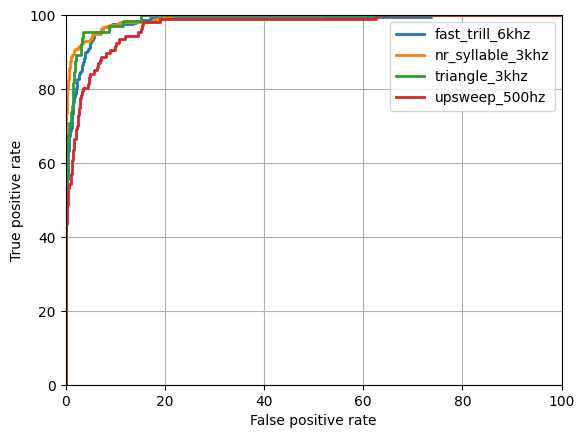

/tmp/ipykernel_104200/1115467876.py:14: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(prec, rec, label=name, linewidth=2, **kwargs)
/tmp/ipykernel_104200/1115467876.py:14: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(prec, rec, label=name, linewidth=2, **kwargs)
/tmp/ipykernel_104200/1115467876.py:14: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(prec, rec, label=name, linewidth=2, **kwargs)
/tmp/ipykernel_104200/

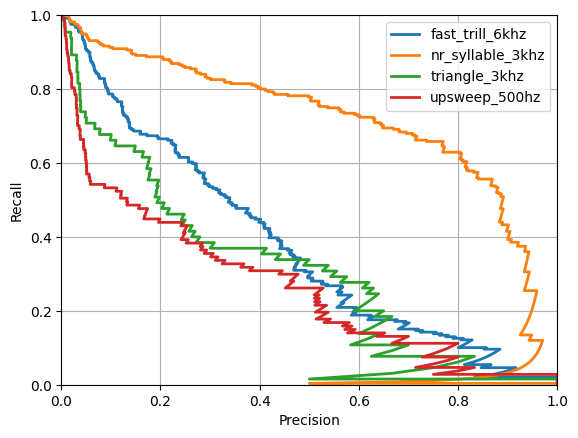

In [23]:
from sklearn.metrics import roc_curve, precision_recall_curve

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(fp*100, tp*100, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.xlim([0,100])
    plt.ylim([0,100])
    plt.grid(True)

def plot_pr(name, labels, predictions, **kwargs):
    prec, rec, _ = precision_recall_curve(labels, predictions)
    plt.plot(prec, rec, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.grid(True)

for i, label in enumerate(labels):
    plot_roc(labels, y_true_flat[:, i], y_pred_flat[:, i])
plt.legend(labels) 
plt.show() 

for i, label in enumerate(labels):
    plot_pr(labels, y_true_flat[:, i], y_pred_flat[:, i])
plt.legend(labels) 
plt.show() 

In [24]:
m = keras.metrics.AUC(curve='roc')
m.update_state(y_true_flat[:, 0], y_pred_flat[:, 0])
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.92988586>

In [25]:
m = keras.metrics.AUC(curve='pr')
m.update_state(y_true_flat[:, 0], y_pred_flat[:, 0])
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.3706826>

In [28]:
mean_average_precision(np.array(y_true_flat), np.array(y_pred_flat))
# also check prec and recal metrics

TypeError: Cannot convert 1.0 to EagerTensor of dtype bool

'1.26.4'

In [20]:
def mean_average_precision(y_true, y_pred):
    # Ensure y_true and y_pred are binary
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Sort predictions
    indices = tf.argsort(y_pred, direction='DESCENDING')
    y_true_sorted = tf.gather(y_true, indices)
    
    # Calculate cumulative precision
    tp = tf.cumsum(y_true_sorted)
    precision = tp / (tf.range(1, tf.shape(y_true_sorted)[0] + 1, dtype=tf.float32))

    # Calculate average precision for each class
    average_precision = tf.reduce_sum(precision * y_true_sorted) / (tf.reduce_sum(y_true_sorted) + tf.keras.backend.epsilon())

    return average_precision

mean_average_precision(y_true_flat, y_pred_flat)

InvalidArgumentError: Incompatible shapes: [88416,4,4] vs. [88416] [Op:RealDiv]

In [21]:
import tensorflow as tf
import tensorflow_recommenders as tfr

map_metric = tfr.keras.metrics.MeanAveragePrecisionMetric()
map_metric.update_state(y_true_flat, y_pred_flat)
final_map = map_metric.result()

ModuleNotFoundError: No module named 'tfr'

In [23]:
model.save('../models/full_training_data_20epochs/model.keras')

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

threshold = 0.5

y_pred_binary = (y_pred >= threshold).astype(int)

precision_metric = Precision()
recall_metric = Recall()

precision_metric.update_state(y_true, y_pred_binary)
recall_metric.update_state(y_true, y_pred_binary)

precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.75789475440979
Recall: 0.3148688077926636
